In [23]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
import yfinance as yf

# For time stamps
from datetime import datetime

yf.pdr_override()

df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.now())
# Show the data
df.head()

plt.rcParams['figure.figsize'] = (20.0, 10.0)

[*********************100%***********************]  1 of 1 completed


In [24]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2799.000000,2799.000000,2799.000000,2799.000000,2799.000000,2.799000e+03
mean,59.517679,60.193780,58.863784,59.555980,57.600067,2.021248e+08
std,48.467403,49.113269,47.853066,48.513456,49.045597,1.713648e+08
min,13.856071,14.271429,13.753571,13.947500,12.046194,3.519590e+07
25%,24.215535,24.433750,24.011250,24.223750,22.027189,9.432060e+07
50%,38.345001,38.532501,37.924999,38.314999,36.219486,1.380234e+08
75%,79.649998,80.337498,79.058750,79.717503,78.191769,2.449916e+08
max,182.630005,182.940002,179.119995,182.009995,180.683868,1.506120e+09


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2799 entries, 2012-01-03 to 2023-02-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2799 non-null   float64
 1   High       2799 non-null   float64
 2   Low        2799 non-null   float64
 3   Close      2799 non-null   float64
 4   Adj Close  2799 non-null   float64
 5   Volume     2799 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 153.1 KB


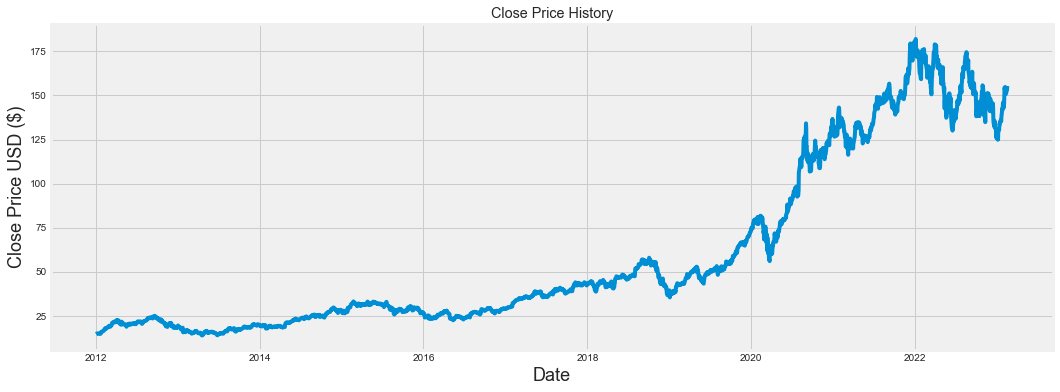

In [26]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [27]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

2660

In [28]:
df1 = df.replace('[\$,]', '', regex=True).astype(float)
df1.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.500196,302220800.0
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.567368,260022000.0
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.706892,271269600.0
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.839727,318292800.0
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.819363,394024400.0


In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
df1.shape

(2799, 6)

In [30]:
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
print(df1)
print('\n df1 present shape : ', df1.shape)

[[1.70984741e-09]
 [1.78335680e-09]
 [1.70036209e-09]
 ...
 [9.51343910e-08]
 [9.51343910e-08]
 [4.35382230e-02]]

 df1 present shape :  (16794, 1)


In [31]:
#splitting data (70/30)
training_size = int(len(df1)*0.7)
test_size = len(df1) - training_size
print('Training Size : ',training_size)
print('Test Size : ',test_size)

train_data, test_data = df1[0:training_size,:],df1[training_size:len(df1),:]
print('Training Data Shape : ', train_data.shape)
print('Test Data Shape: ', test_data.shape)

Training Size :  11755
Test Size :  5039
Training Data Shape :  (11755, 1)
Test Data Shape:  (5039, 1)


In [32]:
#windowing data set
def create_dataset(dataset, window=1):
    dataX, dataY= [], []
    for i in range(len(dataset)-window-1):
        a = dataset[i:(i+window),0]
        dataX.append(a)
        dataY.append(dataset[i+window,0])
    return np.array(dataX), np.array(dataY)

window = 100
X_train, y_train = create_dataset(train_data, window=100)
X_test, y_test = create_dataset(test_data, window=100)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(11654, 100) (11654,)
(4938, 100) (4938,)


In [33]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

#### LSTM

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer = 'adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.fit(X_train,y_train,
          validation_data = (X_test,y_test), 
          epochs = 10, 
          batch_size=64,verbose=1)

Epoch 1/10
183/183 [==============================] - 26s 121ms/step - loss: 0.0058 - val_loss: 7.5409e-04
Epoch 2/10
183/183 [==============================] - 21s 114ms/step - loss: 0.0037 - val_loss: 6.2605e-04
Epoch 3/10
183/183 [==============================] - 21s 115ms/step - loss: 0.0030 - val_loss: 5.2721e-04
Epoch 4/10
183/183 [==============================] - 22s 118ms/step - loss: 0.0015 - val_loss: 1.4349e-04
Epoch 5/10
183/183 [==============================] - 21s 115ms/step - loss: 9.0078e-04 - val_loss: 1.4656e-04
Epoch 6/10
183/183 [==============================] - 21s 115ms/step - loss: 8.9650e-04 - val_loss: 1.1984e-04
Epoch 7/10
183/183 [==============================] - 21s 117ms/step - loss: 7.9549e-04 - val_loss: 3.1242e-04
Epoch 8/10
183/183 [==============================] - 21s 115ms/step - loss: 7.6617e-04 - val_loss: 2.7066e-04
Epoch 9/10
183/183 [==============================] - 21s 115ms/step - loss: 9.6364e-04 - val_loss: 1.2453e-04
Epoch 10/10
183/1

In [36]:
y_pred = scaler.inverse_transform(model.predict(X_test))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test[:5]

155/155 [==============================] - 4s 23ms/step


array([[9.49404000e+07],
       [6.46725006e+01],
       [6.51100006e+01],
       [6.42125015e+01],
       [6.50350037e+01]])

In [37]:
import math
from sklearn.metrics import mean_squared_error

rmse_score = math.sqrt(mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error(test) : ',rmse_score)

Root Mean Squared Error(test) :  27054939.933935706


365/365 [==============================] - 9s 23ms/step


No handles with labels found to put in legend.


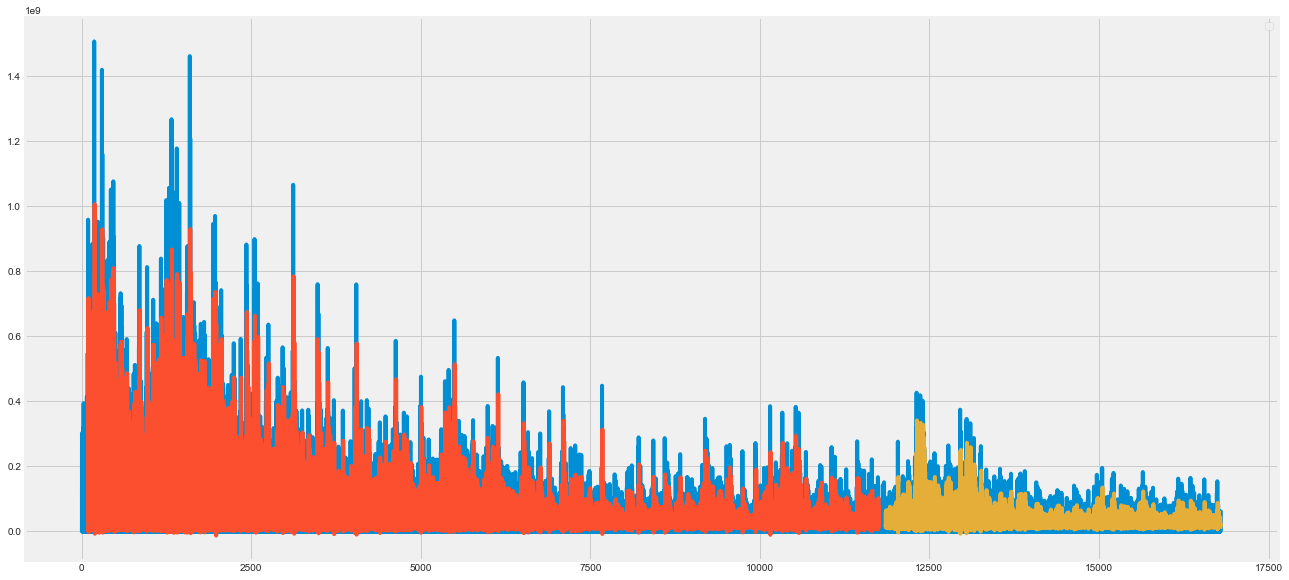

In [38]:
# shift train predictions for plotting
train_predict = scaler.inverse_transform(model.predict(X_train))

look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = y_pred
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend()
plt.show()

### predicting 30 Days future value (Previous 100 days as input)

In [39]:
x_input=test_data[len(test_data)-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [40]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

#print(lst_output)

day_new=np.arange(1,101)
day_pred=np.arange(101,131)

print(scaler.inverse_transform(lst_output))

[[16929032.01084268]
 [17599465.65136215]
 [17516233.21517719]
 [ 9093460.783072  ]
 [13360665.38810879]
 [35270495.3924574 ]
 [21813385.11389676]
 [18669516.82039479]
 [18662579.14758191]
 [13816278.04373281]
 [16195330.32903225]
 [30664697.00652661]
 [23105688.68524554]
 [18345014.39839248]
 [17860434.92488354]
 [14903084.26770882]
 [17570264.58532524]
 [28406314.78122447]
 [23867253.27299108]
 [18943939.23179494]
 [17898042.2734048 ]
 [15680473.93120748]
 [17992139.89632826]
 [26380918.29272374]
 [23856101.93880944]
 [19414257.62170328]
 [18083789.83646593]
 [16369571.67897488]
 [18302156.80536279]
 [24798318.14029763]]


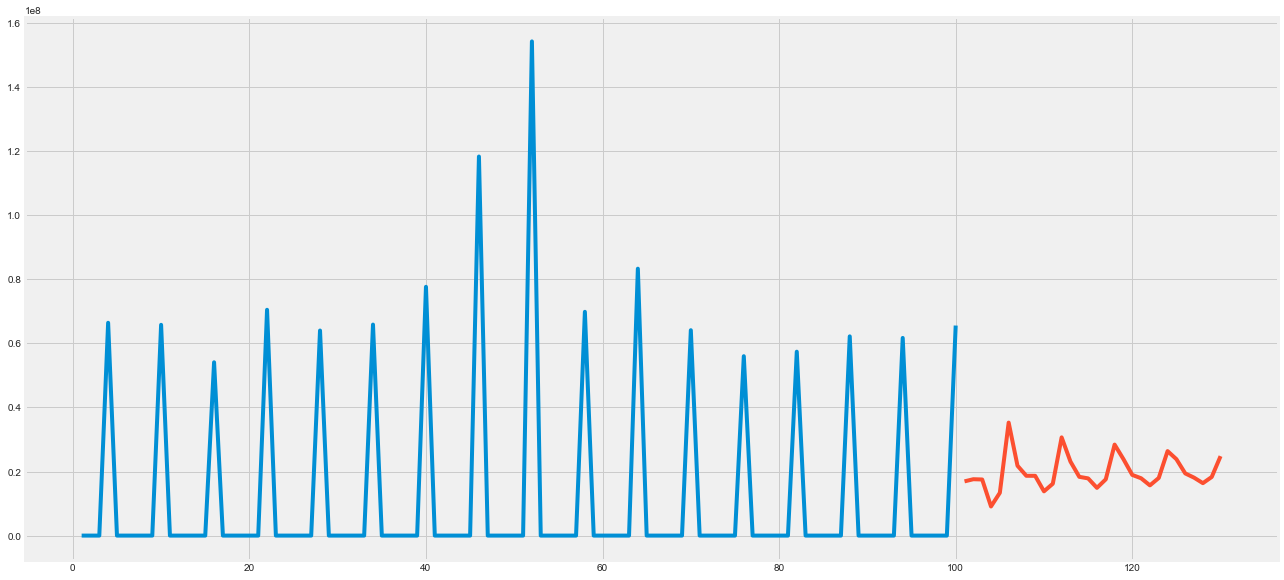

In [41]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))